# Many-Body Tensor Approximation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, transforms

from legendre_decomp import get_eta

/home/pbb/miniconda3/envs/ig/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pbb/miniconda3/envs/ig/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## MNIST

In [3]:
save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Download MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        indices = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(indices):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

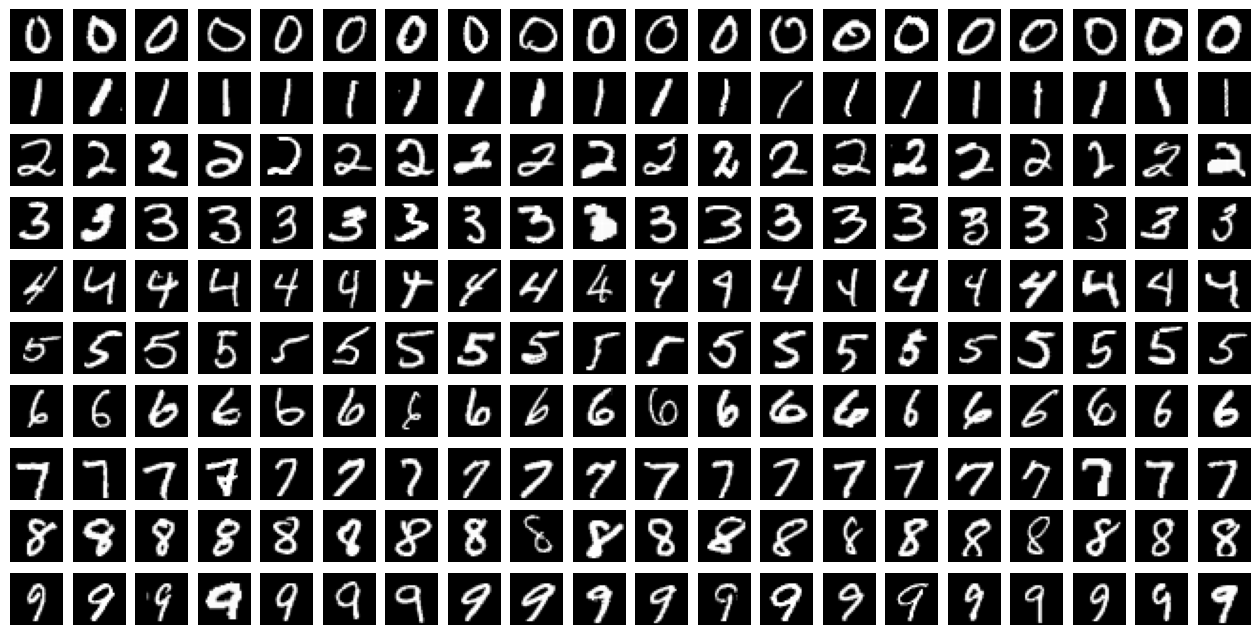

In [4]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Load and display images horizontally for each class
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed
for class_label in range(10):
    class_folder = os.path.join(save_dir, str(class_label))
    images = load_images_from_folder(class_folder)
    for i, img in enumerate(images):
        plt.subplot(10, 20, class_label * 20 + i + 1)
        img = img.resize((28, 28))
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

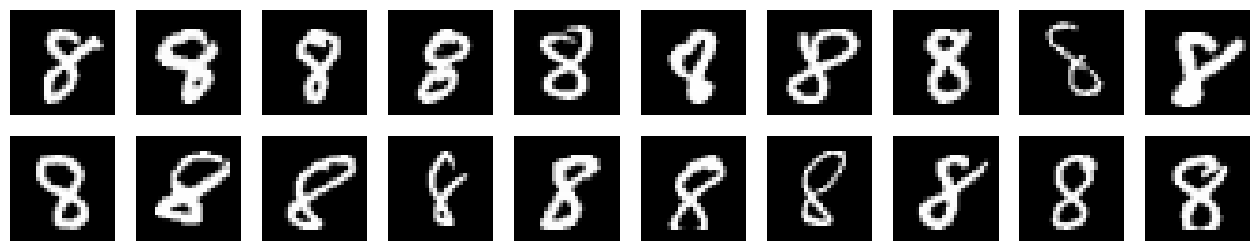

In [5]:
X = []
class_label = 8  # 0-9
class_folder = os.path.join(save_dir, str(class_label))
images = load_images_from_folder(class_folder, max_images=20)

for k in range(1, len(images) + 1):
    img = images[k - 1]
    img = img.resize((28, 28))
    array_obj = np.asarray(img)
    X.append(array_obj)

X = np.array(X)

plt.figure(figsize=(16, 3))
for i in range(X.shape[0]):
    plt.subplot(2, 10, i+1)  # 2 row, 10 columns, current plot index
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')  # Hide axes

plt.show()

### Regression on the Original Manifold

In [6]:
import cupy as cp

eta_hat_list = []

for i in range(X.shape[0]):
    D = len(X[i].shape)
    eps = np.asarray(1.0e-5)
    xp = cp.get_array_module(X[i])
    scaleX = xp.sum(X[i] + eps)
    P = (X[i] + eps) / scaleX
    eta_hat = get_eta(P, D, xp)
    eta_hat_list.append(eta_hat)

In [7]:
# Do a linear approximate of the m-flat submanifold: compute the average eta_hat
eta_hat_list_cp = cp.asarray(eta_hat_list)
average_eta_hat = cp.mean(eta_hat_list_cp, axis=0)
average_eta_hat_np = cp.asnumpy(average_eta_hat)
print("Average eta_hat shape:", average_eta_hat_np.shape)


# Compute the average scale of the images
eps = 1.0e-5
scaleX_sum = 0
for i in range(X.shape[0]):
    xp = cp.get_array_module(X[i])
    scaleX_sum += xp.sum(X[i] + eps)

avg_scaleX = scaleX_sum / X.shape[0]

# Compute RMSE (Relative Mean Squared Error)
rmse = cp.sqrt(cp.mean((eta_hat_list_cp - average_eta_hat) ** 2)) / cp.sqrt(cp.mean(eta_hat_list_cp ** 2))
# Compute RAE (Relative Absolute Error)
rae = cp.sum(cp.abs(eta_hat_list_cp - average_eta_hat)) / cp.sum(cp.abs(eta_hat_list_cp))

rmse_np = cp.asnumpy(rmse)
rae_np = cp.asnumpy(rae)

print("Relative Mean Squared Error (RMSE):", rmse_np)
print("Relative Absolute Error (RAE):", rae_np)

Average eta_hat shape: (28, 28)
Relative Mean Squared Error (RMSE): 0.08588293956045151
Relative Absolute Error (RAE): 0.0802944762135693


### Individual

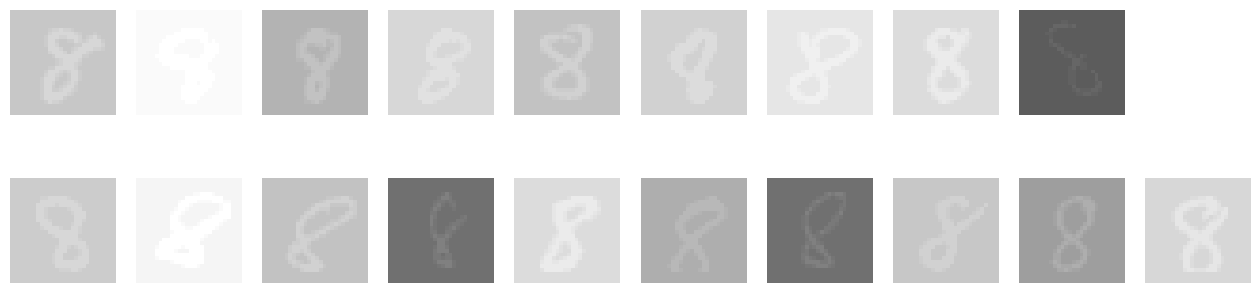

In [8]:
from ld import LD

# Initialize lists to store the results
all_history_kl_list = []
scaleX_list = []
Q_list = []
theta_list = []

# Initialize a list to store reconstructed images
X_recons_list = []

for i in range(X.shape[0]):
    all_history_kl, scaleX, Q, theta = LD(X[i], order=3, verbose=False, n_iter=100, lr=1e-4, exit_abs=True, eps=0)
    all_history_kl_list.append(all_history_kl)
    scaleX_list.append(scaleX)
    Q_list.append(Q)
    theta_list.append(theta)

    X_recons = (Q * scaleX).astype(np.int32)
    X_recons_list.append(X_recons)

plt.figure(figsize=(16, 4))  # Adjust the figure size as needed
for i in range(X.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_recons_list[i], cmap='gray', vmin=0, vmax=50)
    plt.axis('off')  # Hide axes

plt.show()

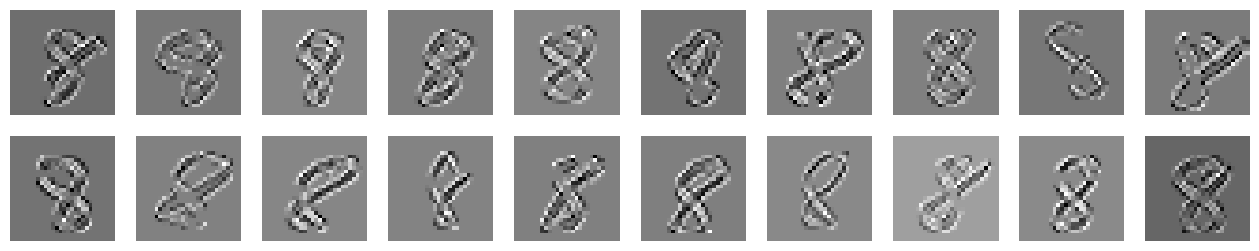

In [9]:
plt.figure(figsize=(16, 3))  # Adjust the figure size as needed
for i in range(X.shape[0]):
    plt.subplot(2, 10, i + 1)  # 2 row, len(X_recons) columns, current plot index
    plt.imshow(theta_list[i], cmap='gray')
    plt.axis('off')  # Hide axes

plt.show()

#### Backward Projection

In [10]:
# Define the start and end indexes of the center region
start_idx = 15
end_idx = 22

# Create the index grid
x, y = np.meshgrid(np.arange(start_idx, end_idx), np.arange(start_idx, end_idx))

# Flatten the arrays and stack them as coordinate pairs
center_region_indexes = np.column_stack((x.flatten(), y.flatten()))

print("Center Region Indexes:")
print(center_region_indexes.shape)

Center Region Indexes:
(49, 2)


43
42
43
42
43
42
42
42
46
42
42
42
43
44
42
43
44
43
43
42


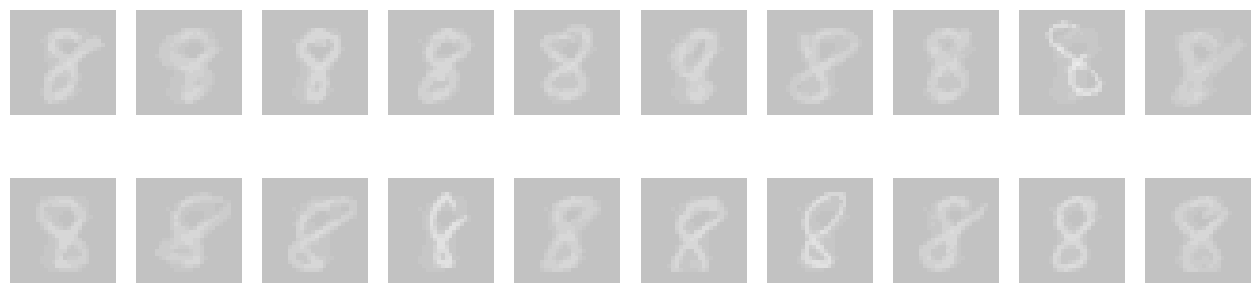

In [11]:
from ld import BP

all_history_kl_list_BP = []
P_list_BP = []
theta_list_BP = []

X_recons_list = []

for i in range(X.shape[0]):
    # add noise to eta_hat
    noisy_eta_hat = average_eta_hat_np + np.random.normal(0, 1e-8, average_eta_hat_np.shape)
    all_history_kl, P, theta = BP(Q_list[i], theta_list[i], noisy_eta_hat, avg_scaleX, B=center_region_indexes, verbose=False, n_iter=100, lr=1e-4, exit_abs=True, eps=0)
    xp = cp.get_array_module(P)
    all_history_kl_list_BP.append(all_history_kl)
    P_list_BP.append(P)
    theta_list_BP.append(theta)

    X_recons = (P).astype(np.int32)
    print(X_recons.max())
    X_recons_list.append(X_recons)


plt.figure(figsize=(16, 4))
for i in range(X.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_recons_list[i], cmap='gray', vmin=0, vmax=50)
    plt.axis('off')
plt.show()

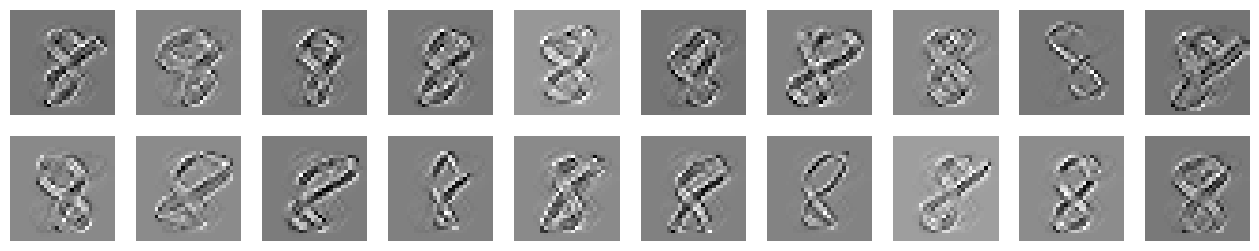

In [12]:
plt.figure(figsize=(16, 3))
for i in range(X.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(theta_list_BP[i], cmap='gray')
    plt.axis('off')
plt.show()

### Batch

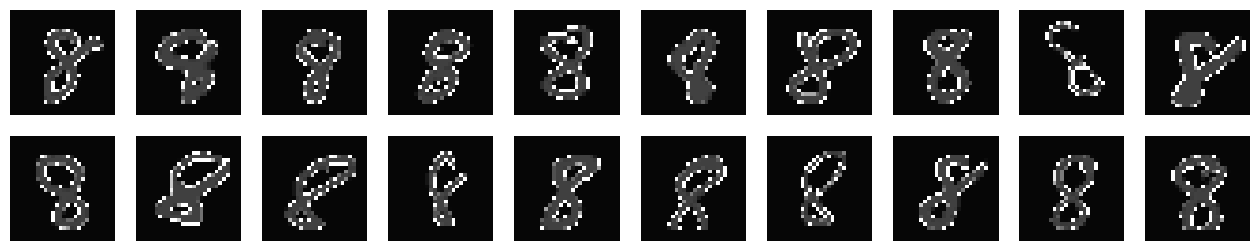

In [13]:
all_history_kl, scaleX, Q, theta = LD(X, order=4, verbose=False)
X_recons = (Q * scaleX).astype(np.int32)

plt.figure(figsize=(16, 3))  # Adjust the figure size as needed
for i in range(len(X_recons)):
    plt.subplot(2, 10, i + 1)  # 2 row, len(X_recons) columns, current plot index
    plt.imshow(X_recons[i], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')  # Hide axes

plt.show()

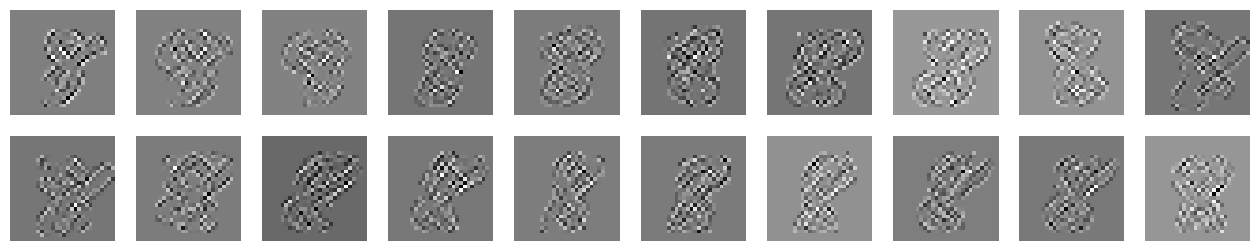

In [14]:
plt.figure(figsize=(16, 3))  # Adjust the figure size as needed
for i in range(len(X_recons)):
    plt.subplot(2, 10, i + 1)  # 2 row, len(X_recons) columns, current plot index
    plt.imshow(theta[i], cmap='gray')
    plt.axis('off')  # Hide axes

plt.show()